<a href="https://colab.research.google.com/github/borgesjose/reconhecimento_de_padroes/blob/master/WEEK%207/dim_reducion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-optimize

     |████████████████████████████████| 100 kB 3.3 MB/s 


In [2]:
pip install xgboost

# Realizar a redução de dimensionalidade com o LDA 

1 - Implementação da redução de dimensionalidade com o PCA provido pela sklearn como opção da função dim_reduction(). Apresentar os gráficos do sistema de coordenadas do PCA e LDA; 

2 - Implementar a combinação PCA+LDA e, finalmente comparar com o desempenho das técnicas individuais e conjuntas, obtidos pelos classificadores para cada redutor de dimensionalidade. Atenção: utilizar a versão da função get_best_model() que vocês desenvolveram na atividade anterior;

In [25]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

import pandas as pd

from numpy import mean
from numpy import std
import matplotlib.pyplot as plt


from sklearn.feature_selection import SelectKBest, chi2

from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC 

import xgboost as xgb

from sklearn.decomposition import PCA

In [4]:
wine = load_wine()
data_x,data_y = wine.data,wine.target
labels = wine.target_names
data_x = StandardScaler().fit_transform(data_x)

In [5]:
def dim_reduction(x_train, y_train, x_test):

  lda = LinearDiscriminantAnalysis(n_components=2)
  lda.fit(x_train,y_train)

  print('Variancia Explicada: ', lda.explained_variance_ratio_)

  x_train_fs = lda.transform(x_train)
  x_test_fs = lda.transform(x_test)

  return x_train_fs, x_test_fs, lda

In [6]:
def get_best_model_2(model_name, opt_name, x, y):
    
    import warnings
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=109) # 70% training and 30% test

    
    if model_name == 'd_tree':
        params = {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
        model = DecisionTreeClassifier()
    elif model_name == 'r_forest':
        params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 1, 3, 5, 7]}
        model = RandomForestClassifier()
    elif model_name == 'svm':
        params = {'C': [1, 10, 50, 100]} #, 'gamma': [0.001, 0.0001]}
        model = SVC()
    elif model_name == 'gxboost':
        params = {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]}
        model = xgb.XGBClassifier()
    else:
        print("Oops! That was no valid model. Try again...")
    
    if opt_name == 'grid':
        grid = GridSearchCV(model,           
                            params,          
                            error_score=0.)  
        grid.fit(X_train, y_train) 

    elif opt_name == 'bayes':

        warnings.filterwarnings("ignore")

        grid = BayesSearchCV(model, params)
        grid.fit(X_train,y_train)

    else:
        print("Oops! That was no valid optmization method. Try again...")

    return grid

In [7]:
def evaluate_model(model, x_test, y_test):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x_test, y_test, scoring= 'accuracy' , cv=cv, n_jobs=-1)
    return scores

In [8]:
# Padronizar escala das variaveis

sc = StandardScaler()
data_x_sc = sc.fit_transform(data_x)

x_train,x_test,y_train, y_test = train_test_split(data_x_sc, data_y, test_size=0.2,random_state=1)

In [9]:
# Redução de dimensionalidade
x_train_fs, x_test_fs, fs = dim_reduction(x_train, y_train, x_test)

# Capturar os melhores parâmetros do modelo
grid = get_best_model_2("r_forest", 'grid', x_train_fs, y_train)
# Instanciar o modelo com os melhores parâmetros e treiná-lo
#model = DecisionTreeClassifier(**grid.best_params_)
model = RandomForestClassifier(**grid.best_params_)
model.fit(x_train_fs, y_train)
# Avaliando o modelo
scores = evaluate_model(model,x_test_fs,y_test)
print( '%s > %.3f (%.3f) ' % ("r_forest",  mean(scores), std(scores)))

Variancia Explicada:  [0.68723957 0.31276043]
r_forest > 0.955 (0.064) 


## 1 - Implementação da redução de dimensionalidade com o PCA provido pela sklearn como opção da função dim_reduction(). Apresentar os gráficos do sistema de coordenadas do PCA e LDA; 

In [43]:
def dim_reduction_2( type ,x_train, y_train, x_test):
  if type == 'lda':
    dim = LinearDiscriminantAnalysis(n_components=2)
    dim.fit(x_train,y_train)

  if type == 'pca':
    dim = PCA(n_components=2)
    dim.fit(x_train,y_train)
  
  print('Variancia Explicada: ', dim.explained_variance_ratio_)

  x_train_fs = dim.transform(x_train)
  x_test_fs = dim.transform(x_test)

  return x_train_fs, x_test_fs, dim

Variancia Explicada:  [0.3580111  0.19652419]
r_forest > 0.943 (0.087) 


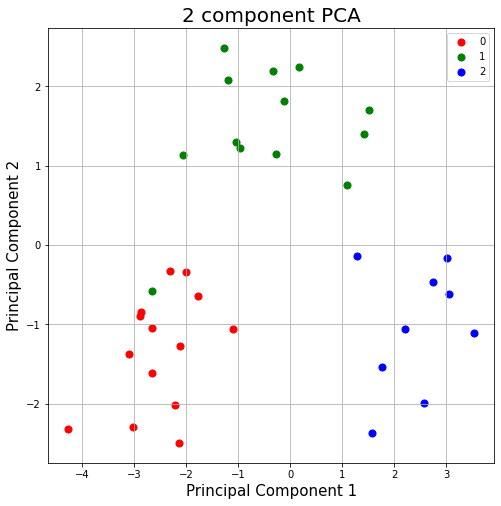

In [44]:
# Redução de dimensionalidade com PCA
x_train_fs, x_test_fs, fs = dim_reduction_2('pca',x_train, y_train, x_test)

# Capturar os melhores parâmetros do modelo
grid = get_best_model_2("r_forest", 'grid', x_train_fs, y_train)
# Instanciar o modelo com os melhores parâmetros e treiná-lo
#model = DecisionTreeClassifier(**grid.best_params_)
model = RandomForestClassifier(**grid.best_params_)
model.fit(x_train_fs, y_train)
# Avaliando o modelo
scores = evaluate_model(model,x_test_fs,y_test)
print( '%s > %.3f (%.3f) ' % ("r_forest",  mean(scores), std(scores)))

principalDf = pd.DataFrame(data = x_test_fs, columns = ['principal component 1', 'principal component 2'])
targetsDf = pd.DataFrame(data = y_test , columns = ['target'])
finalDf = pd.concat([principalDf, targetsDf], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Variancia Explicada:  [0.68723957 0.31276043]
r_forest > 0.964 (0.059) 


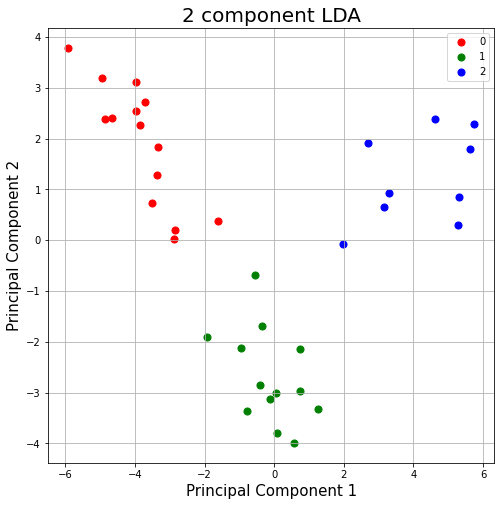

In [45]:
# Redução de dimensionalidade com PCA
x_train_fs, x_test_fs, fs = dim_reduction_2('lda',x_train, y_train, x_test)

# Capturar os melhores parâmetros do modelo
grid = get_best_model_2("r_forest", 'grid', x_train_fs, y_train)
# Instanciar o modelo com os melhores parâmetros e treiná-lo
#model = DecisionTreeClassifier(**grid.best_params_)
model = RandomForestClassifier(**grid.best_params_)
model.fit(x_train_fs, y_train)
# Avaliando o modelo
scores = evaluate_model(model,x_test_fs,y_test)
print( '%s > %.3f (%.3f) ' % ("r_forest",  mean(scores), std(scores)))

principalDf = pd.DataFrame(data = x_test_fs, columns = ['principal component 1', 'principal component 2'])
targetsDf = pd.DataFrame(data = y_test , columns = ['target'])
finalDf = pd.concat([principalDf, targetsDf], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component LDA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## 2 - Implementar a combinação PCA+LDA e, finalmente comparar com o desempenho das técnicas individuais e conjuntas, obtidos pelos classificadores para cada redutor de dimensionalidade. Atenção: utilizar a versão da função get_best_model() que vocês desenvolveram na atividade anterior;